In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.keras import TqdmCallback

import pandas as pd
import numpy as np
import seaborn as sns
from pandas.core.indexing import _IndexSlice
import matplotlib.pyplot as plt
from functools import partial
import umap
from sklearn.preprocessing import StandardScaler
from pandas.core.dtypes.common import is_numeric_dtype, is_object_dtype

from pathlib import Path

import common_functions as fnc

idx: _IndexSlice = pd.IndexSlice

/home/tobias/University/ojip_mlmodel/data_import.py:85: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.3, hspace=0.7)


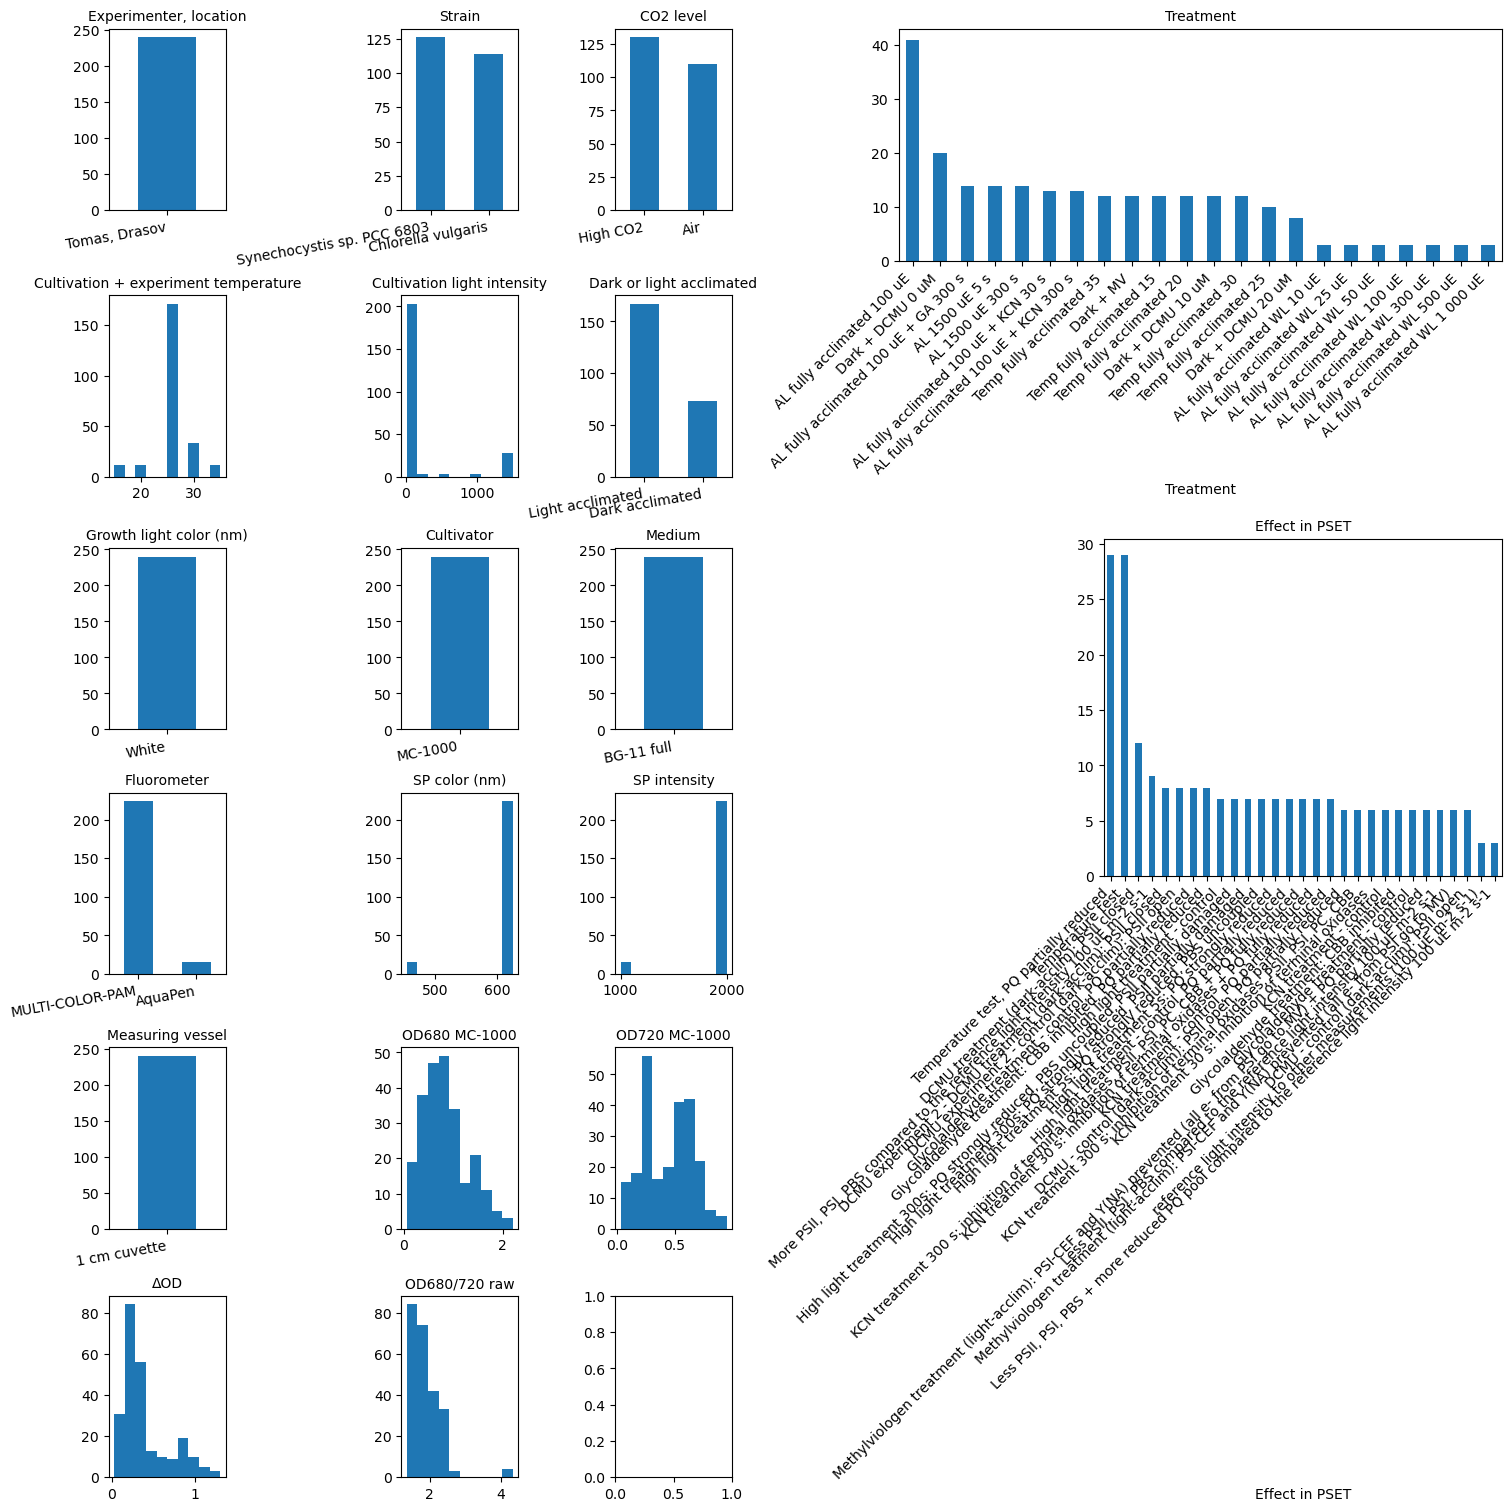

In [2]:
from data_import import df, samples, didx, DATA_PATH

## Example plots

Text(0.5, 1.0, 'AquaPen - Example')

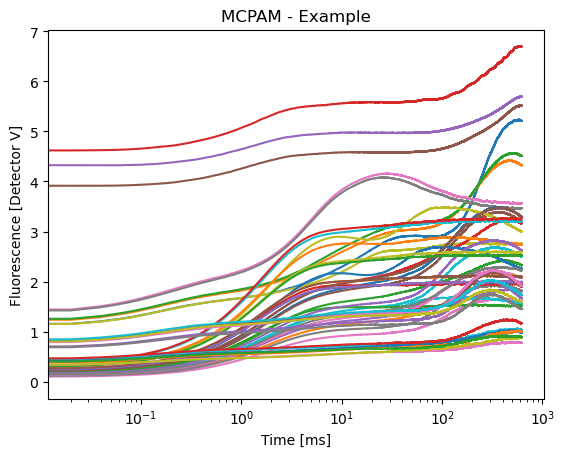

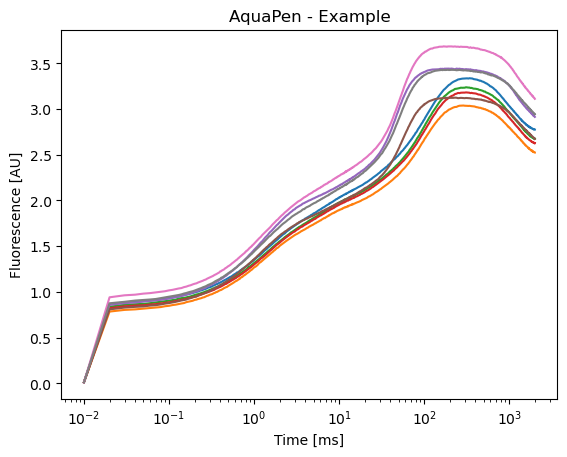

In [3]:
# Example plots
ax = df.loc[:, didx(
    fluorometer="MULTI-COLOR-PAM",
    CO2_level="Air", 
    strain="Chlorella vulgaris",
    # SP_color=455
)].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [Detector V]")
ax.set_title("MCPAM - Example")

ax = df.loc[:, didx(fluorometer="AquaPen", CO2_level="Air")].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [AU]")
ax.set_title("AquaPen - Example")

# Model training

## Select the data to be trained on

In [4]:
dat = df.loc[
    0.01:, : # Exclude data before the light pulse
    # didx(
    #     fluorometer="MULTI-COLOR-PAM", # Only use MCPAM data
    #     strain='Synechocystis sp. PCC 6803', # Only use Synechocystis data
    # )
].dropna()

### Map the treatment effects

In [23]:
# Read the map of effects transformed into one-hot encoding
effects_map = pd.read_csv(
    DATA_PATH / "effects_map.csv",
    header=[0,1],
    index_col=[0,1],
    ).astype(float).fillna(0).astype(bool)

# Exclude Light intensity and temperature from targets
effects_map = effects_map[[
    'control_measurement',
    'PSII_closed',
    'CBB_inhibited',
    'TOX_inhibited',
    'electron_drain'
]]

# Get the effects and map the mto the targets
effects = samples.loc[dat.columns.get_level_values(0), ["Effect in PSET", "Treatment"]]

targets = effects_map.loc[pd.MultiIndex.from_frame(effects)].droplevel(1, axis=1)
targets.index = dat.columns

# Select features

## Get experimental conditions

In [29]:
# Get the conditions as the Multiindex-columns
conditions = dat.columns.to_frame()
# conditions.index = dat.columns.get_level_values(0)

# Select the relevant columns
condition_map = pd.Series({
    'Strain': "str",
    'CO2 level': "float", # There is a meaning to a higher CO2 concentration (maybe make categorical?)
    'Cultivation + experiment temperature': "int",
    'Cultivation light intensity': "int",
    'Dark or light acclimated': "str",
    'Growth light color (nm)': "str",
    'Fluorometer': "str",
    'SP color (nm)': "str", # There is no linear relationship betweeen wavelength and effect
    'SP intensity': "int",
    'OD680 MC-1000': "float",
    'OD720 MC-1000': "float",
})

conditions = conditions[condition_map.index]

# Replace certain column values

# Replace CO2 level with the actual (assumed) numerical ppm
conditions["CO2 level"] = conditions["CO2 level"].replace({
    "Air": "0.0004",
    "High CO2": "0.05"
}).astype(float)

# Replace SP color with categorical value because the numerical gradient is not meaningful
conditions["SP color (nm)"] = conditions["SP color (nm)"].astype(str)

# Encode conditions in one-hot
categorical_conditions = condition_map[condition_map == "str"].index.to_numpy()
numerical_conditions = condition_map[condition_map != "str"].index.to_numpy()



In [88]:
def df_to_dataset(dataframe, targets:list, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.loc[:, targets]
  df = 

  print(df.shape)
  print(labels.shape)

  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in df.items()}
  labels = {key: value.to_numpy()[:,tf.newaxis] for key, value in labels.items()}
  
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [89]:
# Transform into dataset
test = pd.concat([conditions, targets], axis=1)
test2 = df_to_dataset(test, targets=list(targets.columns), shuffle=True, batch_size=1)

(240, 16)
(240, 5)


In [86]:
for i in test2.as_numpy_iterator():
    print(i)
    break

({'Strain': array([[b'Synechocystis sp. PCC 6803']], dtype=object), 'CO2 level': array([[0.0004]]), 'Cultivation + experiment temperature': array([[25]]), 'Cultivation light intensity': array([[100]]), 'Dark or light acclimated': array([[b'Light acclimated']], dtype=object), 'Growth light color (nm)': array([[b'White']], dtype=object), 'Fluorometer': array([[b'MULTI-COLOR-PAM']], dtype=object), 'SP color (nm)': array([[b'625']], dtype=object), 'SP intensity': array([[2000]]), 'OD680 MC-1000': array([[0.82]]), 'OD720 MC-1000': array([[0.43]]), 'control_measurement': array([[False]]), 'PSII_closed': array([[False]]), 'CBB_inhibited': array([[False]]), 'TOX_inhibited': array([[ True]]), 'electron_drain': array([[False]])}, {'control_measurement': array([[False]]), 'PSII_closed': array([[False]]), 'CBB_inhibited': array([[False]]), 'TOX_inhibited': array([[ True]]), 'electron_drain': array([[False]])})


In [87]:
i

({'Strain': array([[b'Synechocystis sp. PCC 6803']], dtype=object),
  'CO2 level': array([[0.0004]]),
  'Cultivation + experiment temperature': array([[25]]),
  'Cultivation light intensity': array([[100]]),
  'Dark or light acclimated': array([[b'Light acclimated']], dtype=object),
  'Growth light color (nm)': array([[b'White']], dtype=object),
  'Fluorometer': array([[b'MULTI-COLOR-PAM']], dtype=object),
  'SP color (nm)': array([[b'625']], dtype=object),
  'SP intensity': array([[2000]]),
  'OD680 MC-1000': array([[0.82]]),
  'OD720 MC-1000': array([[0.43]]),
  'control_measurement': array([[False]]),
  'PSII_closed': array([[False]]),
  'CBB_inhibited': array([[False]]),
  'TOX_inhibited': array([[ True]]),
  'electron_drain': array([[False]])},
 {'control_measurement': array([[False]]),
  'PSII_closed': array([[False]]),
  'CBB_inhibited': array([[False]]),
  'TOX_inhibited': array([[ True]]),
  'electron_drain': array([[False]])})

In [ ]:
fnc.get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')

In [58]:


# df_to_dataset(test.iloc[:10, ], targets=list(targets.columns), shuffle=True)

for i in range(2, test.shape[1]+1):
    df_to_dataset(test.iloc[:10, list(range(i)) + [-1]], targets=["electron_drain"], shuffle=True)
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


## Sample OJIP

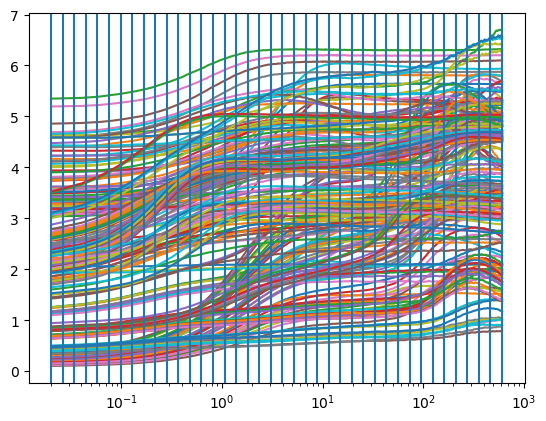

In [22]:
# Select the number of sampled points
n_points = 40

# Time points, logspaced
time_points = np.logspace(
    np.log10(dat.index[0]),
    np.log10(dat.index[-1]),
    n_points
)

# Pre-populate the interp function
_interp = partial(np.interp, time_points, dat.index)

# Interpolate the selected points
ojip_sampled = dat.apply(_interp)
ojip_sampled.index = pd.MultiIndex.from_product([["Fsampled"], time_points])

# Add sampled points to features
ojip_sampled = ojip_sampled.T

# Subset the data to the samples and time to be included in the analysis 
ax = dat.plot(legend=False)

for t in time_points:
    ax.axvline(t)

ax.set_xscale("log")

### UMAP

In [ ]:
# Set a random seed for UMAP
UMAP_seed = 2025

# Scale the features
df_features_scaled = StandardScaler().fit_transform(df_features.values)

# Create the UMAP embedding
reducer = umap.UMAP(random_state=UMAP_seed)
embedding = pd.DataFrame(
    reducer.fit_transform(df_features_scaled),
    index=df_features.index,
    columns=["UMAP_1", "UMAP_2"]
).reset_index()

# Plot
categories = df.columns.names[1:]
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,15),
    sharey=True,
    sharex=True,
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()

In [ ]:
# Plot targest on UMAP
# Add UMAP to targets
embedding_targets = pd.concat([
    targets.droplevel(-1, axis=1).droplevel(list(range(1,20)), axis=0),
    embedding.set_index("Label").loc[:, ["UMAP_1", "UMAP_2"]],
], axis=1)

# Plot
categories = effects_map.columns.get_level_values(0)
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,7),
    sharex=True,
    sharey=True
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding_targets,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding_targets[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()

## Prepare data

In [ ]:
# # Split data
# X_train, X_test, Y_train, Y_test = train_test_split(
#     df_features.astype(int),
#     targets.astype(int), 
#     test_size=0.2, 
#     random_state=42,
#     stratify=targets.values
# )

# if not np.all(Y_train.drop_duplicates().sum(axis=0) == 1):
#     raise RuntimeError("Not all targets are in the training set")

# # Scale data
# scaler_X = StandardScaler().fit(X_train.values)
# scaler_Y = StandardScaler().fit(Y_train.values)

# X_train_scaled = scaler_X.transform(X_train.values)
# X_test_scaled = scaler_X.transform(X_test.values)

# Y_train_scaled = scaler_Y.transform(Y_train.values)
# Y_test_scaled = scaler_Y.transform(Y_test.values)

# print(f"Training model to recognize {Y_train.shape[1]} target features.\nUsing {X_train.shape[0]} samples with {X_train.shape[1]} features.")

## Create machine learning model

In [ ]:
## Define the model
# Define the feature inputs
ojip_input = Input(shape=(X_train_scaled.shape[1],), name="ojip_input")

x = keras.layers.Reshape((X_train_scaled.shape[1],1), name="LSTM_1_reshape")(ojip_input)

# Hidden layer
x = LSTM(64, activation="tanh", name="LSTM_1")(x)
x = Dropout(0.3, name="LSTM_1_Dropout")(x)

# Output layer
output = Dense(Y_train_scaled.shape[1], activation="relu", name="prediction")(x)

model = keras.Model(
    inputs=[ojip_input],
    outputs=[output],
)


##  Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError]
)

##  Train the model
history = model.fit(
    [X_train_scaled],
    [Y_train_scaled],
    validation_split=0.1,
    epochs=500,
    verbose=0,
    batch_size=10,
    callbacks=[TqdmCallback(verbose=1)]
)

plot_loss_development(history)

In [ ]:
model.summary()

# Look at all models

In [ ]:
fig, axes = plt.subplots(len(models_metrics), sharex=True)

for model, ax in zip(models_metrics, axes.flatten()):
    # Plot the model metrics
    models_metrics[model].plot(kind="bar", ax=ax)
    ax.set_title(model)